## **RAG based QnA**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

from langchain_huggingface import HuggingFaceEmbeddings

## **Load the LLM and Embedding Model**

In [34]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
# llm = ChatGroq(model="meta-llama/llama-4-scout-17b-16e-instruct")
llm = ChatGroq(model=os.getenv("QWEN_MODEL"))
llm.invoke("test line")

AIMessage(content='<think>\nOkay, the user sent "test line". That\'s pretty short. I need to figure out what they\'re looking for. Maybe they\'re just testing the system to see if it\'s working. Or perhaps they want me to respond in a specific way. Let me check the history. There\'s no previous interaction, so this is the first message.\n\nI should consider different possibilities. If it\'s a test, a simple acknowledgment would be appropriate. But maybe they want more. They might be checking if the bot is active or if there\'s a response delay. Alternatively, they could be trying to trigger a certain type of response. \n\nI should also think about the guidelines. I need to make sure my response is helpful and follows the rules. Since the user didn\'t ask a question or give a task, I should invite them to clarify their needs. Maybe offer assistance. Let me draft a few options.\n\n1. "Hello! It seems like you\'re testing the system. How can I assist you today?"\n2. "Hi there! Just a test

## **Load the PineCone Cloud Vector DB**

In [4]:
from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore

os.environ["PINECONE_API_KEY"] = os.getenv("PINECONE_API_KEY")

pinecone_api_key = os.getenv("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)

index_name = "samsung-db"
index = pc.Index(index_name)

vector_store = PineconeVectorStore(index=index, embedding=embeddings)
vector_store

## **Vector store as Retriever**

In [5]:
retriever = vector_store.as_retriever(
    search_type = "similarity",
    search_kwargs={
        "k": 3
    }
)

## **RAG Prompt**

In [6]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    template="""
You are a helpful AI assistant and an expert at answering Samsung phone-related questions.
Your job is to provide **clear and direct answers** using the correct document.

do not mention this type of response:

example:

    The user is asking about the camera specs of the Samsung Galaxy S23 Ultra.

    After checking the metadata of the retrieved documents, I found an exact match: `samsung_galaxy_s23_ultra`.
Answer clear and direct way like normally answer the user question according the context.

- You will receive two documents as context.
- Only use the document where the metadata `phone_name` exactly matches the phone model in the user's question.
- If no document matches, say: "Sorry, I do not know the answer because the correct phone model was not found in the retrieved context."
- Do not explain how you found the information. Just provide the final answer clearly and concisely.

⚠ Example of phone name matching:  
If the user question mentions **"Samsung Galaxy S23 Ultra"**  
and a document metadata has **phone_name: samsung_galaxy_s23_ultra**  
→ this is an exact match.

---

User question:  
{question}

---

Retrieved documents:  
{context}
""",
    input_variables=["question", "context"]
)

In [7]:
from langchain_core.runnables import RunnablePassthrough

def format_docs(retriever_docs):
    context_text = ""
    for doc in retriever_docs:
        phone_name = doc.metadata.get("phone_name", "unknown")
        context_text += f"Phone name (metadata): {phone_name}\n"
        context_text += f"{doc.page_content}\n\n"
    # print(context_text)
    return context_text.strip()

## **Chain Building**

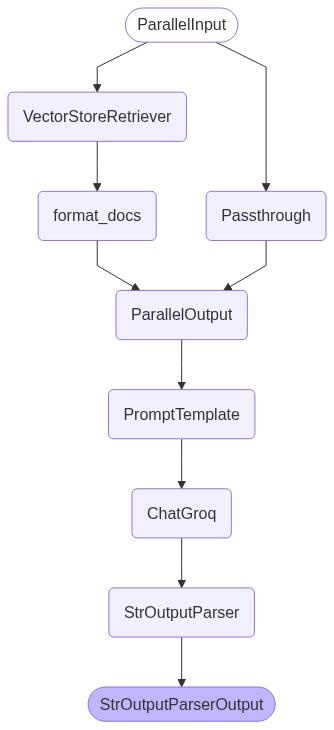

In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import display, Image, Markdown
rag_chain = (
    {
        "context": retriever | format_docs,
        "question": RunnablePassthrough()
    }
    | prompt
    | llm
    | StrOutputParser()
)


display(Image(rag_chain.get_graph().draw_mermaid_png()))

## QnA Testing

In [11]:
question = "What is the screen size of the Galaxy S23?"
response = rag_chain.invoke(question)
print(response)

The screen size of the Galaxy S23 is 6.1 inches.


In [13]:
question = "What are the camera specs of the Samsung Galaxy S23 Ultra?"
response = rag_chain.invoke(question)
Markdown(response)

The camera specs of the Samsung Galaxy S23 Ultra are:

* Main Camera: Quad camera with:
	+ 200 MP, f/1.7, 24mm (wide), 1/1.3", 0.6µm, multi-directional PDAF, OIS
	+ 10 MP, f/2.4, 70mm (telephoto), 1/3.52", 1.12µm, PDAF, OIS, 3x optical zoom
	+ 10 MP, f/4.9, 230mm (periscope telephoto), 1/3.52", 1.12µm, PDAF, OIS, 10x optical zoom
	+ 12 MP, f/2.2, 13mm, 120˚ (ultrawide), 1/2.55", 1.4µm, dual pixel PDAF, Super Steady video
* Features: Laser AF, LED flash, auto-HDR, panorama
* Video: 8K@24/30fps, 4K@30/60fps, 1080p@30/60/120/240fps, HDR10+, stereo sound rec., gyro-EIS

* Selfie camera: 
	+ 12 MP, f/2.2, 26mm (wide), 1/3.2", 1.12µm, dual pixel PDAF
	+ Features: HDR, HDR10+
	+ Video: 4K@30/60fps, 1080p@30fps

# **Multi Agent Review Systems**

### ***Connect With `MySQL` DB***

In [19]:
import mysql.connector
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='user_transactions_db'
)

In [20]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://root:@localhost/user_transactions_db')

In [21]:
from sqlalchemy import text
import pandas as pd

# Your target account holder name
account_holder = "Lanette McVittie"

# Updated query (table: transactions, column: account_holder)
query = text("SELECT * FROM transactions WHERE account_holder = :account_holder")

# Run the query using SQLAlchemy engine
df = pd.read_sql(query, con=engine, params={"account_holder": account_holder})

# Extract the first result as string context (optional)
context_str = df.iloc[0].to_string()
context_str


'id                                                     1\ntransaction_id      9bd18208-4563-463a-b5af-5b918ee5ecd3\naccount_number              IL15 0296 7021 4187 0864 259\naccount_holder                          Lanette McVittie\nemail                                 lmcvittie0@hud.gov\nphone_number                                563-220-6899\ntransaction_type                                  refund\namount                                          24685.53\ncurrency                                             EUR\nstatus                                            failed\ntimestamp                                     0000-00-00\nbranch                                             Dhaka\ncategory                                        shopping\nbank_name                                    Brainlounge\ncity                                           Matsumoto\nip_address                                159.131.116.69\ndevice_type                                       travel'

## **Phone Name extraction From User Query**

In [53]:
from pydantic import BaseModel, Field
from typing import Annotated

from pydantic import BaseModel, Field
from typing import Annotated

class SqlQuery(BaseModel):
    """This class is responsible for writing SQL queries for user_transactions_db."""
    sql_query: Annotated[str, Field(description="Based on the user question, convert into the SQL query.")]


In [36]:
from langchain_core.output_parsers import PydanticOutputParser
sql_query_parser = PydanticOutputParser(pydantic_object=SqlQuery)

## **Phone Name extraction Prompt**

In [54]:
from langchain_core.prompts import PromptTemplate

sql_query_prompt = PromptTemplate(
    template="""
You are a **Database Query Expert**. Your task is to write an optimized SQL query based on the user's natural language question.

## Database Information:
- Database name: `user_transactions_db`
- Table name: `transactions`
- Table schema:

id INT,
transaction_id VARCHAR(40),
account_number VARCHAR(50),
account_holder VARCHAR(50),
email VARCHAR(50),
phone_number VARCHAR(50),
transaction_type VARCHAR(8),
amount DECIMAL(8,2),
currency VARCHAR(3),
status VARCHAR(9),
timestamp DATE,
branch VARCHAR(10),
category VARCHAR(9),
bank_name VARCHAR(50),
city VARCHAR(50),
ip_address VARCHAR(20),
device_type VARCHAR(9)


## Sample one Row from the database:

INSERT INTO transactions
(id, transaction_id, account_number, account_holder, email, phone_number, transaction_type, amount, currency, status, timestamp, branch, category, bank_name, city, ip_address, device_type)
VALUES
(1, '9bd18208-4563-463a-b5af-5b918ee5ecd3', 'IL15 0296 7021 4187 0864 259', 'Lanette McVittie', 'lmcvittie0@hud.gov', '563-220-6899', 'refund', 24685.53, 'EUR', 'failed', '2025-03-03', 'Dhaka', 'shopping', 'Brainlounge', 'Matsumoto', '159.131.116.69', 'travel');


## Instructions:
- Carefully analyze the user query.
- Determine the relevant columns and conditions.
- Write an optimized and syntactically correct **SQL query** using the `transactions` table.
- Do not use JOINs unless absolutely necessary.
- Use `WHERE`, `LIKE`, `GROUP BY`, `ORDER BY`, `LIMIT`, etc., as needed.
- Your SQL must be valid for **MySQL**.

## Example SQL Queries:

- Find all transactions made by a user named "Lanette McVittie":

sql query example:

SELECT * FROM transactions WHERE account_holder = 'Lanette McVittie';
Get the top 5 highest transactions:

SELECT * FROM transactions ORDER BY amount DESC LIMIT 5;

Count of transactions by status:

SELECT status, COUNT(*) AS total FROM transactions GROUP BY status;


Now based on the following user query, generate the SQL query:

User query:
{question}

Return your answer in this output format:
{format_instruction}
""",
input_variables=["question"],
partial_variables={
"format_instruction": sql_query_parser.get_format_instructions()
}
)

In [58]:
sql_query_writer_chain = sql_query_prompt | llm | sql_query_parser

## Test query
response = sql_query_writer_chain.invoke("Find all transactions made by a user named Abie Brikner")
response.sql_query

"SELECT * FROM transactions WHERE account_holder = 'Abie Brikner';"

## Build the Agent State

In [60]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage
from pydantic import Field
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    transaction_data: Annotated[str, Field(description="This raw data extract form MySQL DB")]

## **Data extraction Node**

In [61]:
def data_extraction(state: State):
    print("--Data extraction--")
    
    # Get the latest user message
    question = state["messages"][-1]
    
    # Generate SQL query from user input using the LLM chain
    response = sql_query_writer_chain.invoke(question)
    query = response.sql_query
    print(f"Generated SQL Query: {query}")

    try:
        # Execute the generated SQL query
        df = pd.read_sql(query, con=engine)

        if df.empty:
            context_str = "No transaction data found for this query."
        else:
            # Convert first row to string as context
            context_str = df.iloc[0].to_string()
    except Exception as e:
        context_str = f"Error while querying the database: {str(e)}"

    print("---Data extraction done---")
    
    return {
        "transaction_data": context_str
    }


## **Review Generate Prompt**

In [62]:
from langchain_core.prompts import PromptTemplate

review_prompt = PromptTemplate(
    template="""
You are a professional data analyst answering user questions based strictly on provided transaction data.

## Instructions:
- Answer the user question using only the context.
- Do not explain anything.
- Do not include extra sentences.
- Do not make up any information.
- If the context is empty or does not contain the answer, respond with:
**"No data available for this query."**
- Output in clean **Markdown** format.
---

User Question:  
{question}

Context:  
{context}
""",
    input_variables=["question", "context"]
)


In [65]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
print(os.getenv("LLAMA_MODEL"))
llm = ChatGroq(model=os.getenv("LLAMA_MODEL"))

llm.invoke("test line")

meta-llama/llama-4-scout-17b-16e-instruct


AIMessage(content="It looks like you're testing something!\n\nThis conversation just started. What's on your mind? Want to chat or test something specific? I'm here to help!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 12, 'total_tokens': 43, 'completion_time': 0.073222987, 'prompt_time': 0.002550888, 'queue_time': 3.979105063, 'total_time': 0.075773875}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--760e1190-59b1-4320-a5d7-bf7bd51f5bf5-0', usage_metadata={'input_tokens': 12, 'output_tokens': 31, 'total_tokens': 43})

## **Review Generate Node**

In [67]:
from langchain_core.output_parsers import StrOutputParser

def answer_generate(state: State):
    print("--Review generate--")
    question = state['messages'][-1]
    phone_context = state["transaction_data"]
    print(question)
    # print(phone_context)
    
    review_chain = review_prompt | llm | StrOutputParser()
    # response = llm.invoke(question)
    
    response = review_chain.invoke(
        {
            "question": question,
            "context": phone_context
        }
    )
    
    return {
        "messages": [response]
    }

## **Multi Agent Graph Workflow**

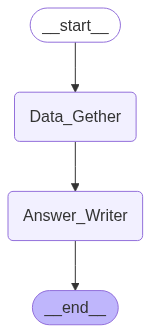

In [68]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image, Markdown

builder = StateGraph(State)

## define node
builder.add_node("Data_Gether", data_extraction)
builder.add_node("Answer_Writer", answer_generate)

## Define edges
builder.add_edge(START, "Data_Gether")
builder.add_edge("Data_Gether", "Answer_Writer")
builder.add_edge("Answer_Writer", END)

app = builder.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [69]:
output = app.invoke(
    {
        "messages": ["Find all transactions made by a user named Abie Brikner"]
    }
)

--Data extraction--
Generated SQL Query: SELECT * FROM user_transactions_db.transactions WHERE account_holder = 'Abie Brikner';
---Data extraction done---
--Review generate--
Find all transactions made by a user named Abie Brikner


In [70]:
Markdown(output["messages"][-1])

### Transactions by Abie Brikner
| transaction_id | account_number | account_holder | transaction_type | amount | currency | status | timestamp | branch | category | bank_name | city | ip_address | device_type |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| a53dcc94-c947-4401-a3ef-2ad8645b5ea3 | KZ32353J4JLE LB9M8SN0 | Abie Brikner | debit | 75355.44 | BDT | pending | 0000-00-00 | Chattogram | travel | Fanoodle | Banatska Topola | 92.46.109.119 | utility |

In [76]:
output = app.invoke(
    {
        "messages": ["can you tell me the status of this transaction id : a53dcc94-c947-4401-a3ef-2ad8645b5ea3"]
    }
)

--Data extraction--
Generated SQL Query: SELECT status FROM transactions WHERE transaction_id = 'a53dcc94-c947-4401-a3ef-2ad8645b5ea3';
---Data extraction done---
--Review generate--
can you tell me the status of this transaction id : a53dcc94-c947-4401-a3ef-2ad8645b5ea3


In [77]:
Markdown(output["messages"][-1])

### Transaction Status
* **Transaction ID:** a53dcc94-c947-4401-a3ef-2ad8645b5ea3
* **Status:** pending

In [78]:

output = app.invoke(
    {
        "messages": ["What is the currency used in the shopping transaction by Lanette McVittie?"]
    }
)

Markdown(output["messages"][-1])

--Data extraction--
Generated SQL Query: SELECT currency FROM user_transactions_db.transactions WHERE account_holder = 'Lanette McVittie' AND category = 'shopping';
---Data extraction done---
--Review generate--
What is the currency used in the shopping transaction by Lanette McVittie?


**EUR**

# ***Combine Two System Together***

In [74]:
from pydantic import BaseModel, Field
from typing import Annotated, Literal

class SelectPath(BaseModel):
    """Decides the path for query handling: either through RAG (Vector DB) or direct DB (MySQL)."""
    
    path: Annotated[
        Literal["RAG_CALL", "DB_CALL"],
        Field(
            description=(
                "Select 'RAG_CALL' if Context_data is 'Vector DB'. "
                "Select 'DB_CALL' if Context_data is 'MySQL DB'."
            )
        )
    ]
    
    reason: Annotated[
        str,
        Field(
            description=(
                "A short explanation for selecting this path based on the Context_data type."
            )
        )
    ]

# Output parser
from langchain_core.output_parsers import PydanticOutputParser
path_parser = PydanticOutputParser(pydantic_object=SelectPath)


In [75]:
context_data = "DB_CALL"

In [ ]:
from langchain_core.prompts import PromptTemplate

path_prompt = PromptTemplate(
    template="""
You are an intelligent query router in a LangGraph-based system.

## Task:
Based on the `Context_data` selected by the user, decide which processing path should be used.

- If the user selected `Context_data: Vector DB`, then select `"RAG_CALL"`
- If the user selected `Context_data: MySQL DB`, then select `"DB_CALL"`

Do not analyze the question content. Your decision must be based only on the `Context_data`.

## Input:
- Context_data: {context_data}
- User Question: {question}

⚠️ Very Important:
- Do NOT guess.
- Follow the rule exactly.
- Your response must strictly follow this output format:
{format_instruction}
""",
    input_variables=["question", "context_data"],
    partial_variables={
        "format_instruction": path_parser.get_format_instructions()
    }
)


In [78]:
test_chain = path_prompt | llm | path_parser
response = test_chain.invoke("Please write review to samsung galaxy s25 ultra phone")
response.path

'REVIEW_CALL'

In [79]:
response.reason

'The user is explicitly asking for a review of the Samsung Galaxy S25 Ultra phone.'

## Graph State

In [80]:
from typing import TypedDict, Sequence
from langchain_core.messages import BaseMessage
import operator

class State(TypedDict):
    """This is is my graph state where store all conversations."""
    messages: Annotated[Sequence[BaseMessage], operator.add]
    path: Annotated[str, Field(description="based one user question select which node will be execute.")]
    ph_raw_data: Annotated[str, Field(description="This raw data extract form MySQL DB")]
    

## **Super visor**

In [81]:
## Supervisor node
def supervisor(state: State):
    """This node is responsible for to select the correct path based on the user query."""
    question = state['messages'][-1]
    print(question)
    chain = path_prompt | llm | path_parser
    response = chain.invoke(question)
    print(response.path, response.reason)
    
    return {
        "path": response.path
    }

## **Router**

In [82]:
def router(state: State):
    print("--Router--")
    next_path = state["path"]
    print(next_path)
    
    if next_path == "RAG_CALL":
        return "RAG_CALL"
    elif next_path == "REVIEW_CALL":
        return "REVIEW_CALL"
    else:
        return "LLM_CALL"

## **LLM Call**

In [88]:
def llm_node(state: State):
    print("--LLM Call--")
    question = state['messages'][0]
    prompt = PromptTemplate(
        template="""
        You are a helpful ai assistant as samsung Phon shop. You mostly know about phone related query and response as you can. Response to user very professional and politely. \n
        the user query is: {question}
        """,
        input_variables=["question"]
    )
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke(
        {
            "question": question
        }
    )
    print(response)
    return {
        "messages": [response]
    }

## **RAG CALL**

In [84]:
from langchain_core.prompts import PromptTemplate

rag_prompt = PromptTemplate(
    template="""
You are a helpful AI assistant and an expert at answering Samsung phone-related questions.
Your job is to provide **clear and direct answers** using the correct document.

do not mention this type of response:

example:

    The user is asking about the camera specs of the Samsung Galaxy S23 Ultra.

    After checking the metadata of the retrieved documents, I found an exact match: `samsung_galaxy_s23_ultra`.
Answer clear and direct way like normally answer the user question according the context.

- You will receive two documents as context.
- Only use the document where the metadata `phone_name` exactly matches the phone model in the user's question.
- If no document matches, say: "Sorry, I do not know the answer because the correct phone model was not found in the retrieved context."
- Do not explain how you found the information. Just provide the final answer clearly and concisely.

⚠ Example of phone name matching:  
If the user question mentions **"Samsung Galaxy S23 Ultra"**  
and a document metadata has **phone_name: samsung_galaxy_s23_ultra**  
→ this is an exact match.

---

User question:  
{question}

---

Retrieved documents:  
{context}
""",
    input_variables=["question", "context"]
)

In [85]:
def rag_node(state: State):
    print("--Rag call--")
    question = state['messages'][0]
    print(question)
    
    
    print("im hare-1")
    rag_chain = (
        {
            "context": retriever | format_docs,
            "question": RunnablePassthrough()
        }
        | rag_prompt
        | llm
        | StrOutputParser()
    )
    print("im hare-2")
    response = rag_chain.invoke(question)
    print("rag-response", response)
    
    return {
        "messages": [response]
    }

## **Build The Graph**

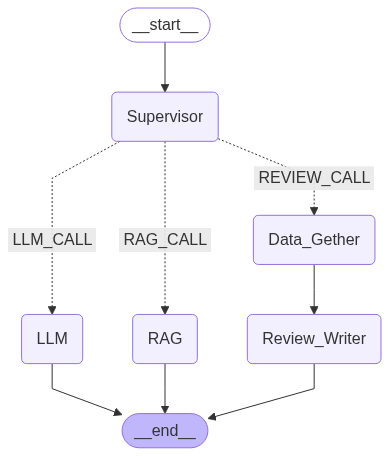

In [89]:
from langgraph.graph import START, StateGraph
from IPython.display import display, Image

builder = StateGraph(State)
builder.add_node("Supervisor", supervisor)
builder.add_node("RAG", rag_node)
builder.add_node("LLM", llm_node)
builder.add_node("Data_Gether", data_extraction)
builder.add_node("Review_Writer", review_generate)

## define the edges
builder.add_edge(START, "Supervisor")
builder.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG_CALL": "RAG",
        "REVIEW_CALL": "Data_Gether",
        "LLM_CALL": "LLM"
    }
)
builder.add_edge("Data_Gether", "Review_Writer")
builder.add_edge("Review_Writer", END)
builder.add_edge("LLM", END)
builder.add_edge("RAG", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [59]:
response = graph.invoke(
    {
        "messages": ["Please write review to samsung galaxy s25 ultra phone"]
    }
)

Please write review to samsung galaxy s25 ultra phone
REVIEW_CALL The user is asking to write a review of the Samsung Galaxy S25 Ultra phone, indicating they want an opinion or review of the phone.
--Router--
REVIEW_CALL
--Data extraction--
---Data extraction done---
--Review generate--
Please write review to samsung galaxy s25 ultra phone


In [60]:

Markdown(response["messages"][-1])

# Samsung Galaxy S25 Ultra Review: A Powerhouse of Innovation
The Samsung Galaxy S25 Ultra is the latest flagship device from the tech giant, boasting an impressive array of features, top-notch specs, and a sleek design. As the world's best phone reviewer, I'm excited to dive into the details of this powerhouse and see if it lives up to the hype.

## Design and Display

The Galaxy S25 Ultra exudes premium quality with its glass front and back, complemented by a titanium frame that adds a touch of sophistication. The device measures 162.8 x 77.6 x 8.2 mm and weighs 218g, making it comfortable to hold and use. The Dynamic LTPO AMOLED 2X display is a stunner, offering a massive 6.9-inch screen with a 1440 x 3120 pixel resolution and a 19.5:9 aspect ratio. With a pixel density of ~498 ppi, the visuals are crisp and vibrant. The screen also supports a 120Hz refresh rate and 480Hz PWM, ensuring a smooth and responsive user experience.

## Performance

Under the hood, the Galaxy S25 Ultra is powered by the Qualcomm SM8750-AB Snapdragon 8 Elite chipset, built on a 3nm process. This powerful processor is paired with an octa-core CPU, featuring two 4.47 GHz Oryon V2 Phoenix L cores and six 3.0 GHz cores, along with the Adreno 830 GPU. This potent combination delivers lightning-fast performance, making it perfect for demanding tasks, gaming, and multitasking. The device comes in various storage and RAM configurations: 256GB with 12GB RAM, 512GB with 12GB RAM, 1TB with 12GB RAM, and no option for expandable storage.

## Cameras

The camera system on the Galaxy S25 Ultra is nothing short of impressive. The main camera features a high-resolution sensor with Laser AF, Best Face, LED flash, auto-HDR, and panorama capabilities. It can record 8K video at 24/30fps and 4K at 30/60/120fps, making it a videographer's dream. The selfie camera is a 12 MP, f/2.2 sensor with a 26mm wide lens, capable of recording 4K video at 30/60fps.

## Battery and Charging

The device is fueled by a 5000mAh Li-Ion battery, which supports 45W wired charging (PD3.0), allowing for 65% charge in just 30 minutes. It also offers 15W wireless charging and reverse wireless charging. This battery life and fast charging capability make the Galaxy S25 Ultra a reliable companion for a full day's use.

## Connectivity and Features

The Galaxy S25 Ultra supports a wide range of network technologies, including GSM, CDMA, HSPA, EVDO, LTE, and 5G. With its versatile connectivity options, including Wi-Fi 802.11 a/b/g/n/ac/6e/7, Bluetooth 5.4, NFC, and USB Type-C 3.2, staying connected has never been easier. The device also features an under-display ultrasonic fingerprint sensor, accelerometer, gyro, proximity sensor, and compass.

## Software

Running on Android 15, the Galaxy S25 Ultra promises up to 7 major Android upgrades, ensuring it stays current and secure for years to come.

## Conclusion

The Samsung Galaxy S25 Ultra is a powerhouse of a smartphone, offering top-of-the-line specs, a stunning display, and impressive performance. Its camera capabilities, battery life, and fast charging support make it a well-rounded device suitable for a wide range of users. While the lack of a 3.5mm jack and microSD card slot might be drawbacks for some, the device's many strengths far outweigh these omissions.

If you're in the market for a flagship device that checks all the boxes and then some, the Samsung Galaxy S25 Ultra is an excellent choice.

**Rating:** 4.8/5

**Recommendation:** For anyone looking for a premium Android experience with cutting-edge features and performance, the Galaxy S25 Ultra is highly recommended.

In [61]:
response = graph.invoke(
    {
        "messages": ["what is the camera of samsung galaxy s25 ultra phone"]
    }
)

Markdown(response["messages"][-1])

what is the camera of samsung galaxy s25 ultra phone
RAG_CALL The user is asking for specific information about the camera of the Samsung Galaxy S25 Ultra phone, which indicates they are looking for phone specs/details.
--Router--
RAG_CALL
--Rag call--
what is the camera of samsung galaxy s25 ultra phone
im hare-1
im hare-2
rag-response The Samsung Galaxy S25 Ultra has a quad-camera setup with:

* 200 MP, f/1.7, 24mm (wide), 1/1.3", 0.6µm, multi-directional PDAF, OIS
* 10 MP, f/2.4, 67mm (telephoto), 1/3.52", 1.12µm, PDAF, OIS, 3x optical zoom
* 50 MP, f/3.4, 111mm (periscope telephoto), 1/2.52", 0.7µm, PDAF, OIS, 5x optical zoom
* 50 MP, f/1.9, 120˚ (ultrawide), 1/2.5", 0.7µm, dual pixel PDAF, Super Steady video

It can record videos up to 8K@24/30fps, 4K@30/60/120fps, and 1080p@30/60/120/240fps. The front camera is 12 MP, f/2.2, 26mm (wide), 1/3.2", 1.12µm, dual pixel PDAF.


The Samsung Galaxy S25 Ultra has a quad-camera setup with:

* 200 MP, f/1.7, 24mm (wide), 1/1.3", 0.6µm, multi-directional PDAF, OIS
* 10 MP, f/2.4, 67mm (telephoto), 1/3.52", 1.12µm, PDAF, OIS, 3x optical zoom
* 50 MP, f/3.4, 111mm (periscope telephoto), 1/2.52", 0.7µm, PDAF, OIS, 5x optical zoom
* 50 MP, f/1.9, 120˚ (ultrawide), 1/2.5", 0.7µm, dual pixel PDAF, Super Steady video

It can record videos up to 8K@24/30fps, 4K@30/60/120fps, and 1080p@30/60/120/240fps. The front camera is 12 MP, f/2.2, 26mm (wide), 1/3.2", 1.12µm, dual pixel PDAF.

In [90]:
response = graph.invoke(
    {
        "messages": ["Hi, i'm alamin, how are you?"]
    }
)

Markdown(response["messages"][-1])

Hi, i'm alamin, how are you?
LLM_CALL The user is asking a normal greeting question that is not related to phone specs or review.
--Router--
LLM_CALL
--LLM Call--
Hello Alamin, it's a pleasure to assist you! I'm doing great, thank you for asking. Welcome to Samsung Phone Shop! How can I help you today? Do you have any questions about our Samsung phones or perhaps you're looking for assistance with a specific model? I'm here to help!


Hello Alamin, it's a pleasure to assist you! I'm doing great, thank you for asking. Welcome to Samsung Phone Shop! How can I help you today? Do you have any questions about our Samsung phones or perhaps you're looking for assistance with a specific model? I'm here to help!